In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA2'

In [1]:
!du -sh /home/roman/mne_data


60G	/home/roman/mne_data


In [1]:
import sys, os, torch
from tqdm import tqdm
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# BNCI2014004 Dataset 2b (Graz)

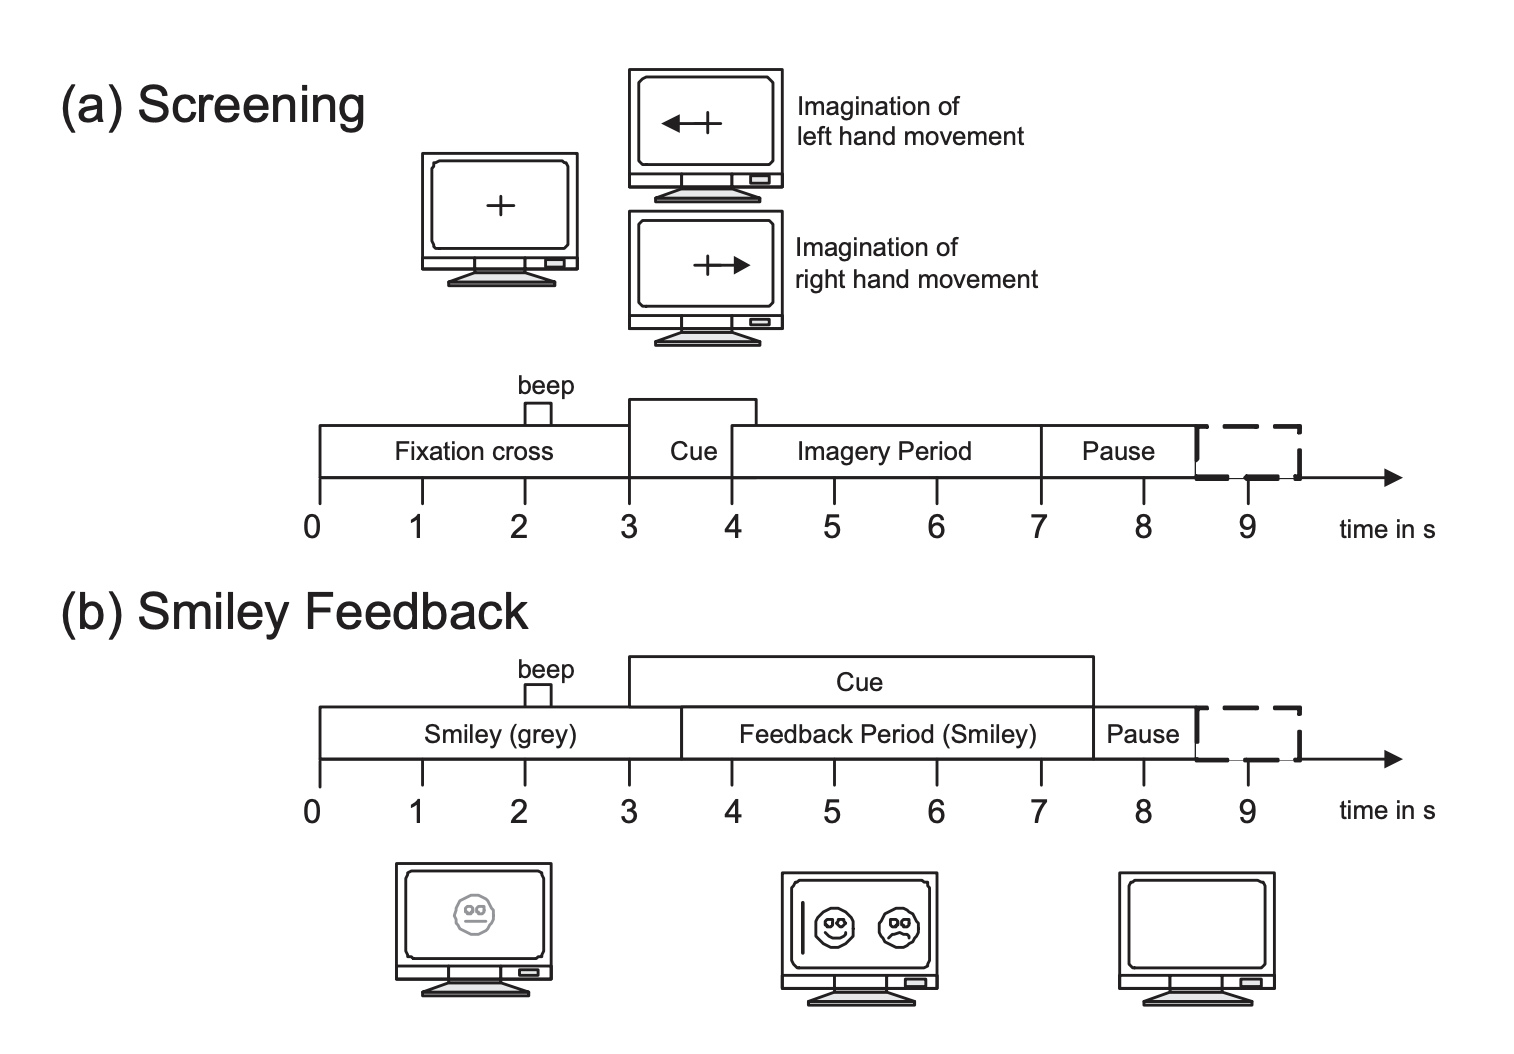

In [21]:
%%time

ds = BNCI2014004()

print(f'N_subj: {len(ds.subject_list)}')


# ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
ChOI = ['C3', 'Cz', 'C4'] # for this dataset, it's only 3 channels
eventsOI  = ['left_hand', 'right_hand']

subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=4, # the MI task if from 4 to 7 seconds in each trial
                            tmax=7, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)
    print(ch_names)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)



N_subj: 9


  0%|                                                                                                                                   | 0/9 [00:00<?, ?it/s]

['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 11%|█████████████▋                                                                                                             | 1/9 [00:10<01:26, 10.75s/it]

(720, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 22%|███████████████████████████▎                                                                                               | 2/9 [00:21<01:13, 10.56s/it]

(680, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 33%|█████████████████████████████████████████                                                                                  | 3/9 [00:31<01:03, 10.59s/it]

(720, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 44%|██████████████████████████████████████████████████████▋                                                                    | 4/9 [00:42<00:52, 10.58s/it]

(740, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 56%|████████████████████████████████████████████████████████████████████▎                                                      | 5/9 [00:52<00:42, 10.56s/it]

(740, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 67%|██████████████████████████████████████████████████████████████████████████████████                                         | 6/9 [01:03<00:31, 10.56s/it]

(720, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▋                           | 7/9 [01:13<00:21, 10.53s/it]

(720, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8/9 [01:24<00:10, 10.61s/it]

(760, 3, 180), ['left_hand' 'right_hand']
['left_hand', 'right_hand']
['C3', 'Cz', 'C4', 'EOG1', 'EOG2', 'EOG3', 'stim']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:35<00:00, 10.61s/it]

(720, 3, 180), ['left_hand' 'right_hand']
CPU times: user 1min 32s, sys: 3.24 s, total: 1min 35s
Wall time: 1min 35s


In [22]:
labelsToIDs = {"right_hand": 0, "left_hand": 1}

def save_to_torch(samples, meta, ds):    
    torch.save({'samples': torch.from_numpy(samples).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ChOI,
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

In [23]:
ChOI, samples.shape

(['C3', 'Cz', 'C4'], (6520, 3, 180))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


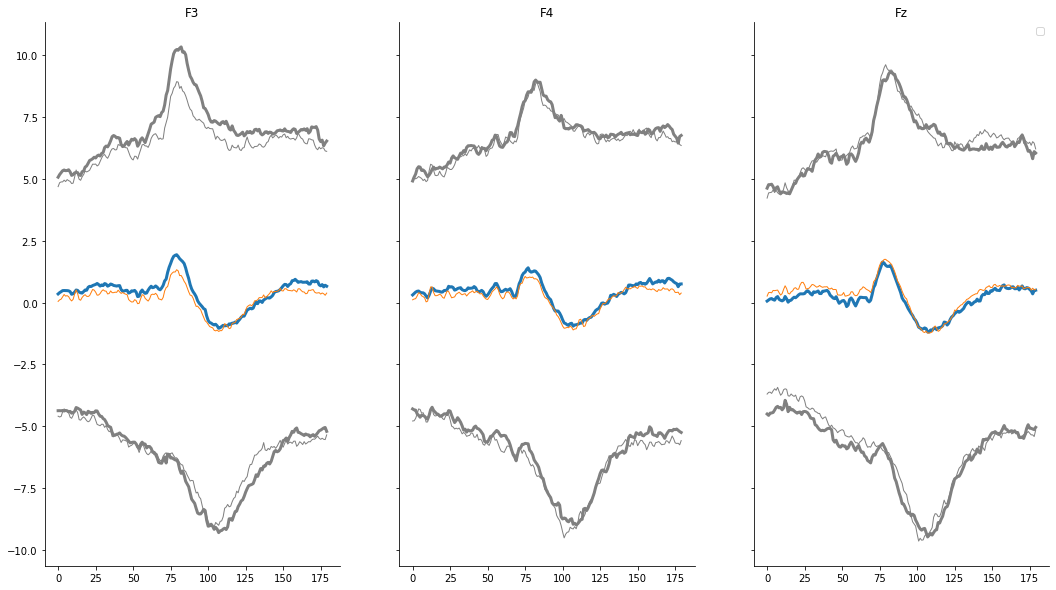

In [24]:
rights = np.where(meta.label.map(labelsToIDs) == 0)[0]
lefts = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1, len(ChOI), figsize=(18,10), sharey=True)
for i in range(len(ChOI)):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[lefts,i,:].mean(0).squeeze()
    s = samples[lefts,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='left_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()

In [25]:
samples.shape

(6520, 3, 180)